In [1]:
import sys
import pkg_resources

# Get Python version
python_version = sys.version.split(" ")[0]

# Define the packages
packages = ["numpy", "pandas", "scipy", "scikit-learn", "dill", "joblib", "psutil", "pip", "surmise"]

# Get package versions, skipping those that are not installed
package_versions = {}
for pkg in packages:
    try:
        package_versions[pkg] = pkg_resources.get_distribution(pkg).version
    except pkg_resources.DistributionNotFound:
        package_versions[pkg] = "Not installed"

print(f"Python version: {python_version}")
for pkg, version in package_versions.items():
    print(f"{pkg}: {version}")

Python version: 3.11.8
numpy: 1.26.4
pandas: 2.2.1
scipy: 1.12.0
scikit-learn: 1.5.1
dill: 0.3.8
joblib: 1.3.2
psutil: 5.9.8
pip: 24.0
surmise: 0.0.0


/var/folders/w7/ygz14_194fs1mqhvr0jwdcc80000gn/T/ipykernel_55036/3590732199.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


# Emulator train and test : No k-fold

In [2]:
import sys, os
sys.path.append(os.path.abspath('../../surmise/emulationmethods'))
sys.path.append(os.path.abspath('../../surmise'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
import matplotlib.pyplot as plt
import dill
import gzip

from emulation import emulator
from AKSGP import Emulator as emulator_AKSGP
from PCGP_scikit import Emulator as PCGP_scikit

import logging

# Configure logging for the Emulator class
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', 
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)


# Load training data
train_dir = 'simulation_data/Pb_Pb_2760_Grad/train'
X = np.loadtxt(os.path.join(train_dir, 'X.txt'))
Ymean = np.loadtxt(os.path.join(train_dir, 'Ymean.txt'))
Ystd = np.loadtxt(os.path.join(train_dir, 'Ystd.txt'))

# for quick tests
numdesignpt = 300
numobs = 4
X = X[:numdesignpt, :]
Ymean = Ymean[:numdesignpt,:numobs]
Ystd = Ystd[:numdesignpt,:numobs]


### Train and save emulators

In [3]:
xloc = np.arange(Ymean.shape[1])  # refers to the observable indices

In [4]:
# Uncomment to train and save emulators. 

methods = ['PCGP', 'PCGP_scikit', 'PCSK', 'AKSGP']  # specify only the emulators you want to train

emus = {}
for method in methods:

    if method == 'PCGP':
        prior = {'min': np.min(Ymean.T), 'max': np.max(Ymean.T)}
        args = {'prior': prior}
        emus[method] = emulator(x=xloc, theta=X, f=Ymean.T, method=method, args=args)
        
    elif method == 'PCSK':
        args = {'simsd': Ystd.T}
        emus[method] = emulator(x=xloc, theta=X, f=Ymean.T, method=method, args=args)
        
    elif method == 'AKSGP':
        emus[method] = emulator_AKSGP(X=X, Y_mean=Ymean, Y_std=Ystd)
        emus[method].fit(kernel='AKS', nrestarts=10, seed=None)
        
    elif method == 'PCGP_scikit':
        emus[method] = PCGP_scikit(X=X, Y=Ymean, npc = 10)
        emus[method].fit(nrestarts=10)
        
    else:
        logger.error(f"Unknown method '{method}'.\n")
        continue
        
    # Saving the emulators after training
    try:
        filename = f'emulator_{method}.dill.gz'
        with gzip.open(filename, 'wb') as f:
            dill.dump(emus[method], f)
        logger.info(f"Emulator '{method}' trained and saved.\n")
    except Exception as e:
        logger.error(f"Failed to save emulator '{method}': {e}\n")
            


2024-09-09 20:53:35 - __main__ - INFO - Emulator 'PCGP' trained and saved.

/Users/jaiswal/miniconda3/envs/jssims_new/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 998.2049999999999. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/jaiswal/miniconda3/envs/jssims_new/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 5 of parameter k1__k2__length_scale is close to the specified lower bound 0.671716. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/jaiswal/miniconda3/envs/jssims_new/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 6 of parameter k1__k2__length_scale is close to the specified lower

### Load saved emulators

In [5]:
emulators = {}
for method in ['PCGP', 'PCGP_scikit', 'PCSK', 'AKSGP']:
    filename = f'emulator_{method}.dill.gz'
    with gzip.open(filename, 'rb') as f:
        emulators[method] = dill.load(f)

### Compute metrics

In [6]:
import pandas as pd
from metrics import *
from sklearn.preprocessing import StandardScaler

# Load testing data
test_dir = 'simulation_data/Pb_Pb_2760_Grad/test'

X_test = np.loadtxt(os.path.join(test_dir, 'X.txt'))
Ymean_test = np.loadtxt(os.path.join(test_dir, 'Ymean.txt'))
Ystd_test = np.loadtxt(os.path.join(test_dir, 'Ystd.txt'))


Ymean_test = Ymean_test[:numdesignpt,:numobs]
Ystd_test = Ystd_test[:numdesignpt,:numobs]

def metrics_cal(means1, var1, means2, var2):
    # Initialize array's to store the distances
    kl_div = np.zeros(means1.shape)
    wasserstein_dist = np.zeros(means1.shape)
    hellinger_dist = np.zeros(means1.shape)
    
    # Loop over each pair of means and variances
    for i in range(means1.shape[0]):
        for j in range(means1.shape[1]):
            mu1 = means1[i, j]
            mu2 = means2[i, j]
            var1_ij = var1[i, j]
            var2_ij = var2[i, j]
            
            # Calculate the distances for the current pair
            kl_div[i, j] = kl_divergence_gaussian(mu1=mu1, Cov1=var1_ij, mu2=mu2, Cov2=var2_ij)
            hellinger_dist[i, j] = hellinger_distance_gaussian(mu1=mu1, Cov1=var1_ij, mu2=mu2, Cov2=var2_ij)
            wasserstein_dist[i, j] = wasserstein_distance_gaussian(mu1=mu1, Cov1=var1_ij, mu2=mu2, Cov2=var2_ij)

    return kl_div, hellinger_dist, wasserstein_dist


scaler_Y = StandardScaler()
Ymean_test = scaler_Y.fit_transform(Ymean_test)
Ystd_test = Ystd_test / scaler_Y.scale_



# Initialize a list to store the results
results = []

for method, emu in emulators.items():
    # print(method)
    
    if method in {'PCGP', 'PCSK'}:
        pred = emu.predict(x=xloc, theta=X_test)
        predmean = pred.mean().T
        predvar = pred.var().T
        
        predmean = scaler_Y.transform(predmean)
        predvar = np.square(np.sqrt(predvar)/scaler_Y.scale_)
        
    elif method in {'AKSGP', 'PCGP_scikit'}:
        predmean, predstd = emu.predict(X_test)
        predvar = np.square(predstd)

        predmean = scaler_Y.transform(predmean)
        predvar = np.square(np.sqrt(predvar)/scaler_Y.scale_)
    
    Yvar_test = np.square(Ystd_test)
    
    EC = intervalstats(Ymean_test, predmean, predvar)
    RMSE = rmse(Ymean_test, predmean)
    NRMSE = normalized_rmse(Ymean_test, predmean)
    KLdiv, HD, WD = metrics_cal(predmean, predvar, Ymean_test, Yvar_test)

    # Store the results in the list
    results.append({
        'Method': method,
        '95% Coverage': '{:.6f}'.format(EC[0]),
        'PI Width': '{:.6f}'.format(EC[1]),
        'RMSE': '{:.6f}'.format(RMSE),
        'NRMSE': '{:.6f}'.format(NRMSE),
        'KL Divergence': '{:.6f}'.format(np.mean(KLdiv)),
        'Hellinger Distance': '{:.6f}'.format(np.mean(HD)),
        'Wasserstein Distance': '{:.6f}'.format(np.mean(WD)),
        'Training time (s)': '{:.6f}'.format(emu.trainwallclocktime),
        'Prediction time (s)': '{:.6f}'.format(emu.predictwallclocktime),
    })

# Convert the list of results into a DataFrame
results_df = pd.DataFrame(results)


2024-09-09 20:54:27 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [7]:
# Get all the methods from the dataframe
methods = results_df['Method'].values

# Create the transposed header with methods
header = f"{'Metric':<30}" + " ".join([f"{method:<15}" for method in methods])
print(header)
print('-' * len(header))

# Define the metrics to transpose (including the new ones)
metrics = ['95% Coverage', 'PI Width', 'RMSE', 'NRMSE', 'KL Divergence', 'Hellinger Distance', 'Wasserstein Distance', 
           'Training time (s)', 'Prediction time (s)']

# Print each metric row with values for each method
for metric in metrics:
    row = f"{metric:<30}" + " ".join([f"{results_df.loc[index, metric]:<15}" for index in range(len(methods))])
    print(row)

    if metric == 'Wasserstein Distance':
        print('-' * len(header))
        
print('-' * len(header))

Metric                        PCGP            PCGP_scikit     PCSK            AKSGP          
---------------------------------------------------------------------------------------------
95% Coverage                  0.908602        0.967742        0.873656        0.884409       
PI Width                      0.727235        0.952633        0.811478        0.749150       
RMSE                          0.215053        0.243941        0.248784        0.229805       
NRMSE                         0.051420        0.058327        0.059494        0.055017       
KL Divergence                 20.942500       32.780621       29.081159       24.569754      
Hellinger Distance            0.675628        0.707023        0.696260        0.681411       
Wasserstein Distance          0.235710        0.295790        0.270833        0.249846       
---------------------------------------------------------------------------------------------
Training time (s)             7.761672        16.943299     

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import kl_div

def evaluate_gaussian_metrics(Ymean_test, Yvar_test, predmean, predvar):
    # Define the parameters of two Gaussian distributions
    # Ymean_test, Yvar_test = 0.000001, 1  # Mean and variance of the first Gaussian
    
    # Create a range of x values
    x = np.linspace(-8, 8, 1000)

    # Compute the PDFs (Probability Density Functions) for both distributions
    pdf1 = norm.pdf(x, predmean, np.sqrt(predvar))
    pdf2 = norm.pdf(x, Ymean_test, np.sqrt(Yvar_test))  # Take square root of variance to pass as standard deviation

    # Plot the two distributions
    plt.figure(figsize=(6, 4))
    plt.plot(x, pdf1, label=f'Approx. distribution', color='blue', lw=2)
    plt.plot(x, pdf2, label=f'True distribution', color='red', lw=2)
    # plt.title('Gaussian Distributions')
    plt.xlabel('x')
    # plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Assuming the functions are correctly defined and imported
    RMSE = rmse(Ymean_test, predmean)
    EC = intervalstats(Ymean_test, predmean, predvar)
    KLdiv = kl_divergence_gaussian(mu1=predmean, Cov1=predvar, mu2=Ymean_test, Cov2=Yvar_test)
    HD = hellinger_distance_gaussian(mu1=predmean, Cov1=predvar, mu2=Ymean_test, Cov2=Yvar_test)
    WD = wasserstein_distance_gaussian(mu1=predmean, Cov1=predvar, mu2=Ymean_test, Cov2=Yvar_test)

    # Initialize a list to store the results
    results = []

    # Store the results in the list
    results.append({
        'RMSE': '{:.6f}'.format(RMSE),
        '95% Coverage': '{:.6f}'.format(EC[0]),
        'KL Divergence': '{:.6f}'.format(np.mean(KLdiv)),
        'Hellinger Distance': '{:.6f}'.format(np.mean(HD)),
        'Wasserstein Distance': '{:.6f}'.format(np.mean(WD)),
    })

    # Convert the list of results into a DataFrame
    results_df = pd.DataFrame(results)

    # Print the formatted output
    header = f"{'Metric':<25}" 
    print(header)
    print('-' * 35)

    # Define the metrics to transpose (including the new ones)
    metrics = ['RMSE', '95% Coverage', 'KL Divergence', 'Hellinger Distance', 'Wasserstein Distance']

    # Print each metric row
    for metric in metrics:
        row = f"{metric:<25}" + f"{results_df[metric].values[0]:<15}"
        print(row)

    print('-' * 35)


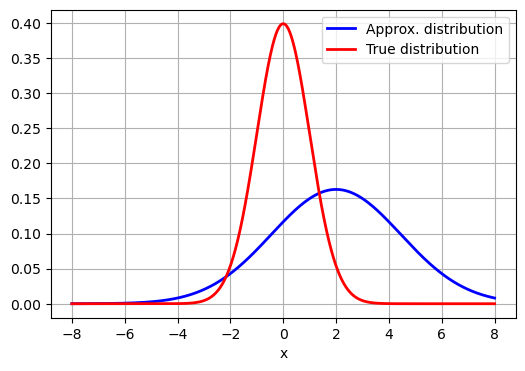

Metric                   
-----------------------------------
RMSE                     2.000000       
95% Coverage             1.000000       
KL Divergence            3.604120       
Hellinger Distance       0.524207       
Wasserstein Distance     2.470024       
-----------------------------------


In [239]:
# Call the function with predmean and predvar
evaluate_gaussian_metrics(0,1,predmean=2, predvar=6)


In [252]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Simulate noisy linear relationship y(x) = x + epsilon
x1 = 1
x2 = 2
noise_std = 0.5
N = 1000

Y_x1 = x1 + noise_std * np.random.randn(N)  # 1000 outputs for x1 with noise
Y_x2 = x2 + noise_std * np.random.randn(N)  # 1000 outputs for x2 with noise

# Stack the results in a 2D array: each row is a different simulation run
Y = np.vstack([Y_x1, Y_x2])

# Calculate the covariance matrix
cov_matrix = np.cov(Y)
print(cov_matrix)

# # Create a heatmap of the covariance matrix
# plt.figure(figsize=(6, 4))
# sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title("Covariance Matrix Heatmap for y(x) = x + noise")
# plt.show()

[[0.2509911  0.00119246]
 [0.00119246 0.24180599]]


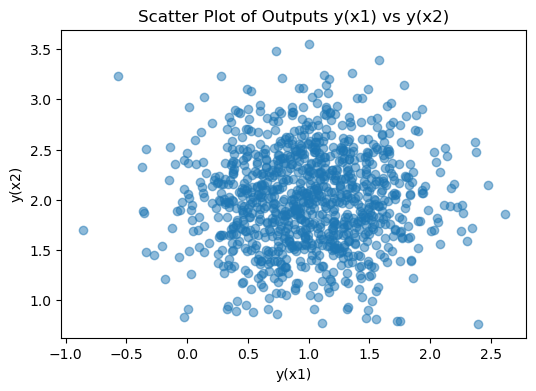

In [246]:
# Scatter plot of Y_x1 vs Y_x2
plt.figure(figsize=(6, 4))
plt.scatter(Y_x1, Y_x2, alpha=0.5)
plt.title("Scatter Plot of Outputs y(x1) vs y(x2)")
plt.xlabel("y(x1)")
plt.ylabel("y(x2)")
plt.show()

In [301]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Simulate noisy linear relationship y(x) = x + poisson noise
x1 = 1
x2 = 2
N = 100000

# Generate Poisson-distributed noise
lambda_poisson = 3  # Lambda (rate) parameter for the Poisson distribution
noise_x1 = np.random.poisson(lambda_poisson, N)  # Poisson noise for x1
noise_x2 = np.random.poisson(lambda_poisson, N)  # Poisson noise for x2
# Create outputs for y(x1) and y(x2) with Poisson noise
Y_x1 = x1 + noise_x1  # 1000 outputs for x1 with Poisson noise
Y_x2 = x2 + noise_x2  # 1000 outputs for x2 with Poisson noise


#----------------------------------------------
# Generate Gaussian-distributed noise
# noise_std = 0.5

# Y_x1 = x1 + noise_std * np.random.randn(N)  # 1000 outputs for x1 with noise
# Y_x2 = x2 + noise_std * np.random.randn(N)  # 1000 outputs for x2 with noise

# Stack the results in a 2D array: each row is a different simulation run
Y = np.vstack([Y_x1, Y_x2])

# Calculate the covariance matrix
cov_matrix = np.cov(Y)
print("Covariance Matrix:\n", cov_matrix/np.max(cov_matrix))


# # Plot the histogram of the Poisson-distributed noise
# plt.figure(figsize=(8, 6))
# sns.histplot(noise_x1, bins=range(np.min(noise_x1), np.max(noise_x1) + 1), kde=False)
# plt.title("Poisson Distribution for Noise with $\lambda$ = {}".format(lambda_poisson))
# plt.xlabel("Noise Value")
# plt.ylabel("Frequency")
# plt.show()

Covariance Matrix:
 [[1.         0.00226834]
 [0.00226834 0.99955917]]


In [ ]:
Covariance Matrix:
 [[0.71643014 0.09699791]
 [0.09699791 1.        ]]